### Global Validation ###

This notebook combines several validation notebooks: `global_validation_tasmax_v2.ipynb` and `global_validation_dtr_v2.ipynb` along with `check_aiqpd_downscaled_data.ipynb` to create a "master" global validation notebook. It also borrows validation code from the ERA-5 workflow, `validate_era5_hourlyORdaily_files.ipynb`. It is intended to be run with `papermill`. 

### Data Sources ###

Coarse Resolution: 
- CMIP6 
- Bias corrected data 
- ERA-5

Fine Resolution: 
- Bias corrected data 
- Downscaled data 
- ERA-5 (fine resolution)
- ERA-5 (coarse resolution resampled to fine resolution) 

### Types of Validation ### 

Basic: 
- maxes, means, mins  
    - CMIP6, bias corrected and downscaled 
    - historical (1995-2014), 2020-2040, 2040-2060, 2060-2080, 2080-2100 
- differences between historical and future time periods for bias corrected and downscaled
- differences between bias corrected and downscaled data 

Variable-specific: 
- GMST
- days over 95 (future-historical difference plots)
- max # of consecutive dry days, highest precip amount over 5-day rolling window

In [1]:
# in case you're modifying external modules while running stuff from this notebook
# %load_ext autoreload
# %autoreload

In [2]:
! pip install xclim # we don't have this package on compute.impactlab ;

  Using cached xclim-0.31.0-py3-none-any.whl (416 kB)
  Using cached boltons-21.0.0-py2.py3-none-any.whl (193 kB)
  Using cached jsonpickle-2.0.0-py2.py3-none-any.whl (37 kB)


In [3]:
%matplotlib inline 
import xarray as xr
import numpy as np
import dask
import dask.array as da
import dask.distributed as dd
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 

from science_validation_manual import *
import rhg_compute_tools.kubernetes as rhgk

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


### Parametrizing ###

In [4]:
gcm = 'CAMS-CSM1-0'
ssp = 'ssp370' # ssp options: 'ssp126', 'ssp245', 'ssp370', 'ssp585'
variable = 'tasmax' # variable options: 'tasmax', 'tasmin', 'dtr', 'pr'
argo_token = ''
number_of_workers = 4

### Set up a cluster ### 

In [ ]:
client, cluster = rhgk.get_standard_cluster()

In [6]:
cluster.scale(number_of_workers)

In [ ]:
# very important piece of code !
# client.restart() # clear all tasks - otherwise cluster won't scale down
# cluster.scale(0)
# client.close()
# cluster.close()

### Retrieving data paths from workflow ### 

In [8]:
from models_QC import QC_models_dict
models_ID_dict = QC_models_dict()
workflow = models_ID_dict[gcm]
workflow_location = 'archived-workflows' 
manifest = get_manifest(workflow_identifier=workflow, auth_token=argo_token, workflow_location=workflow_location)
data_dict = collect_paths(manifest, gcm, ssp, variable)

### Pre-determined options ### 

In [2]:
# data output types for running validation 
cmip6 = True
bias_corrected = True
downscaled = True
basic_diagnostics = True
basic_diagnostic_types = ['min','mean','max']
gmst = False # takes too long
hot_days = True
difference_plots = True
projection_time_period = '2080_2100' # for difference plots, '2020_2040', '2040_2060', '2060_2080', '2080_2100'
units = {'tasmax': 'K', 'tasmin': 'K', 'dtr': 'K', 'pr': 'mm'}
maps_color_range = {'tasmax': [260, 320]}
years = {'hist': {'start_yr': '1995', 'end_yr': '2014'}, 
              '2020_2040': {'start_yr': '2020', 'end_yr': '2040'}, 
              '2040_2060': {'start_yr': '2040', 'end_yr': '2060'}, 
              '2060_2080': {'start_yr': '2060', 'end_yr': '2080'}, 
              '2080_2100': {'start_yr': '2080', 'end_yr': '2100'}}
years_test = {'hist': {'start_yr': '1995', 'end_yr': '2014'}, 
              '2020_2040': {'start_yr': '2020', 'end_yr': '2040'}, 
              '2040_2060': {'start_yr': '2040', 'end_yr': '2060'}}

In [10]:
# we only plot gmst if validation variable is tasmax 
if variable != 'tasmax': 
    gmst = False
    hot_days = False
    warnings.warn("gmst plotting option changed to False since validation variable is not tasmax")

### Validation ### 

### for [CMIP6, bias_corrected, downscaled], basic diagnostic plots: [min, mean, max] ### 

CPU times: user 6.21 s, sys: 345 ms, total: 6.56 s
Wall time: 1min 26s


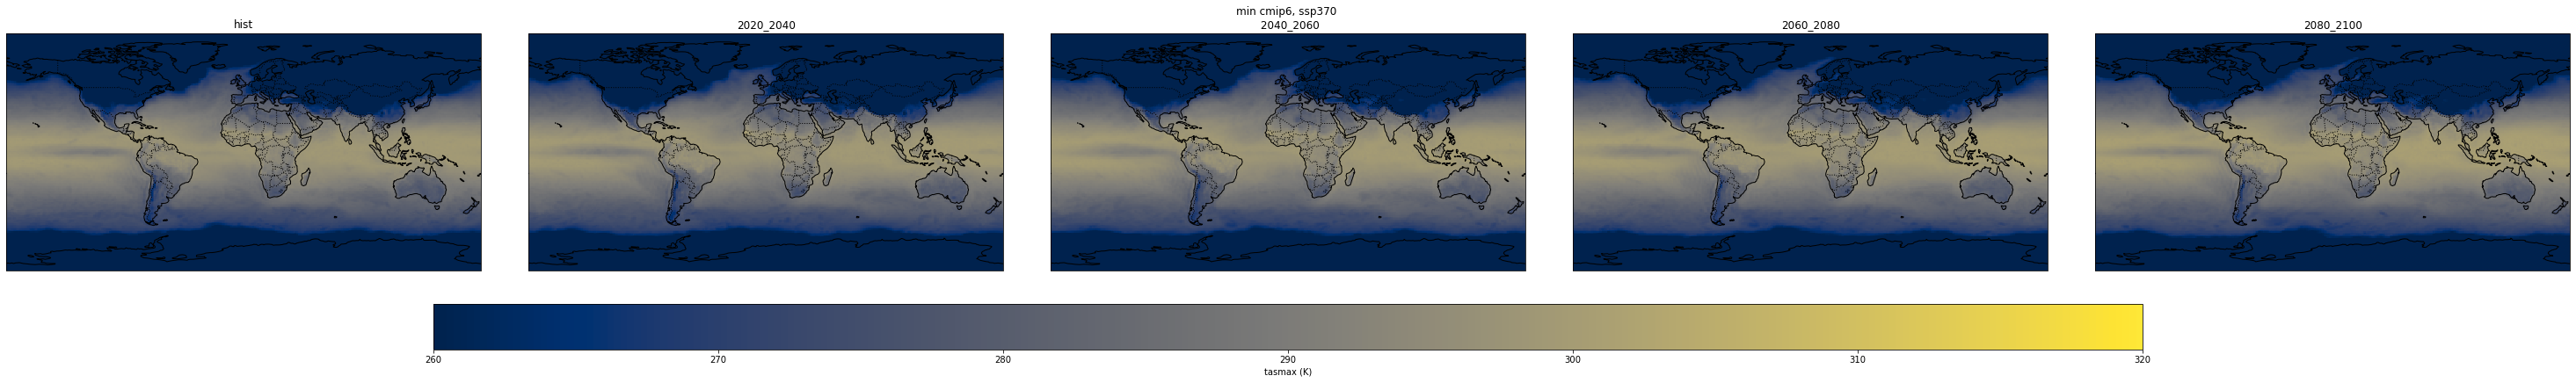

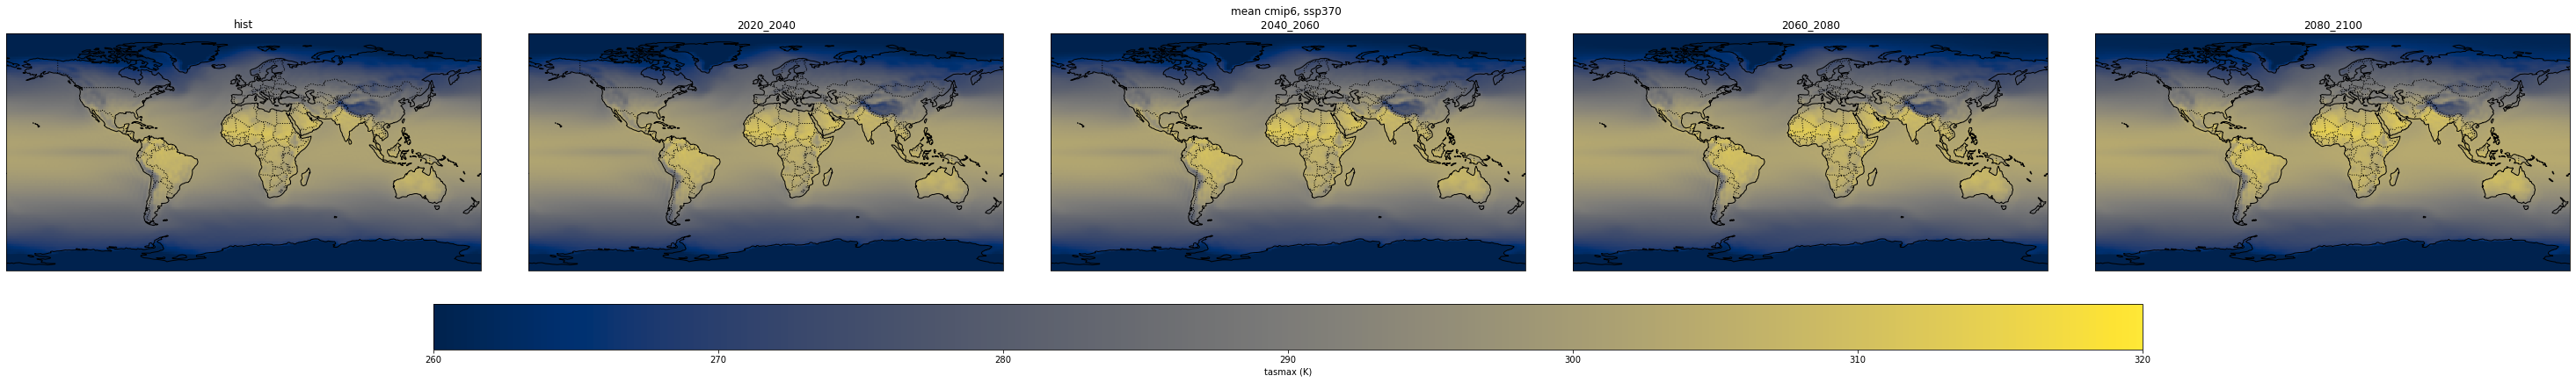

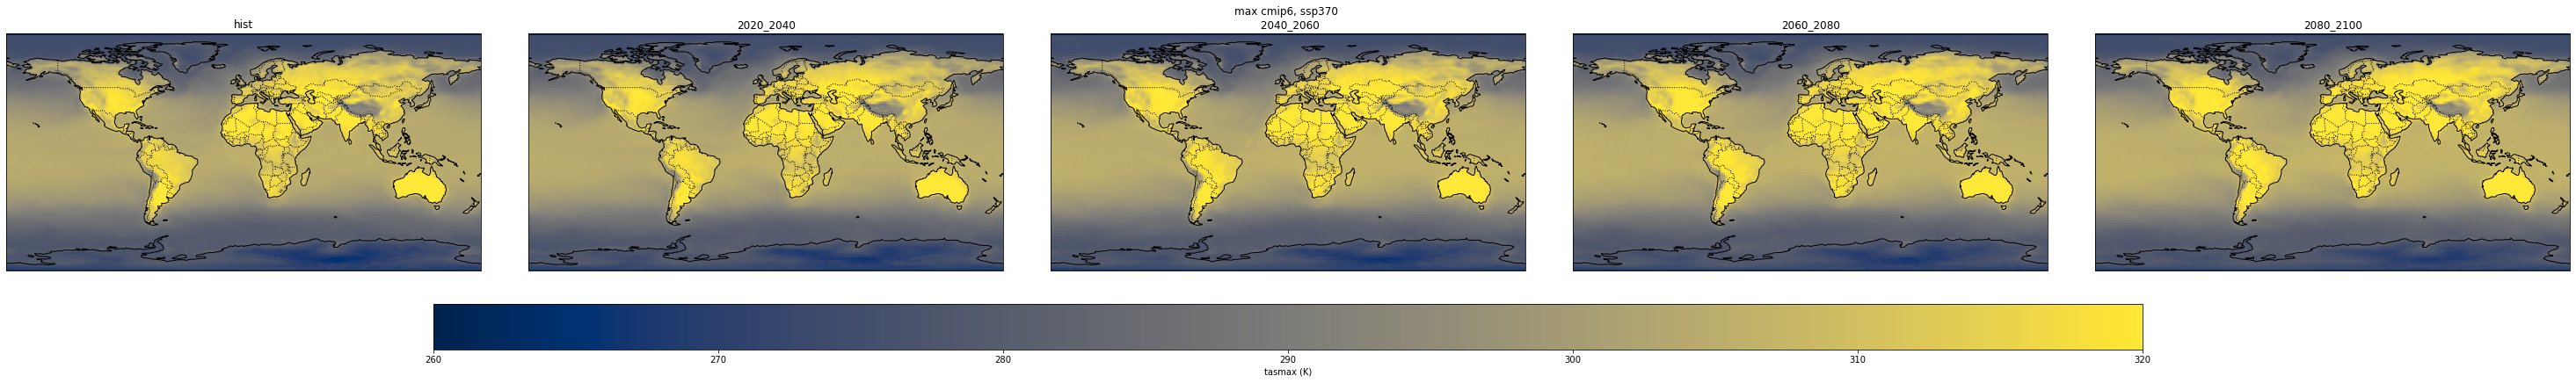

In [11]:
%%time 
if cmip6 and basic_diagnostics:
    for stat in basic_diagnostic_types: 
            plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                          ssp, years, variable, stat, 'cmip6', 
                                          units[variable], ds_hist=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']), 
                                          vmin=maps_color_range[variable][0], vmax=maps_color_range[variable][1])

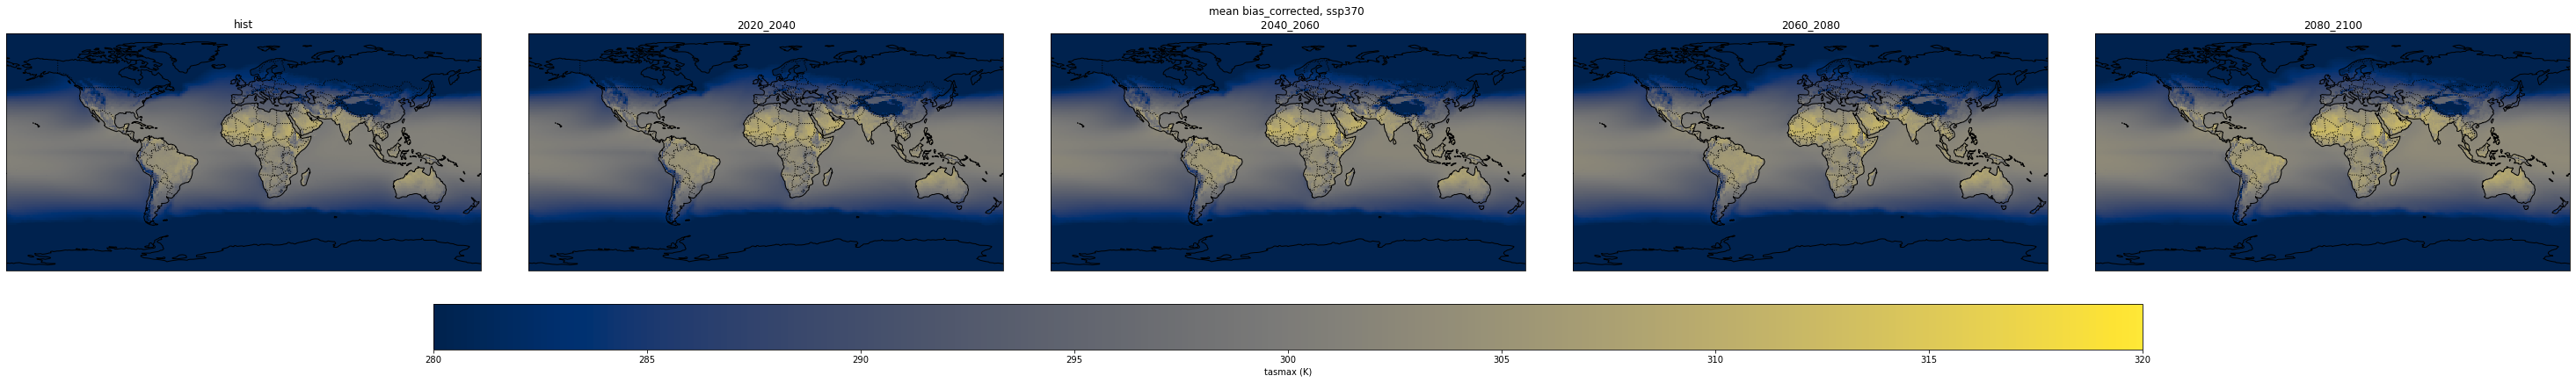

In [35]:
if bias_corrected and basic_diagnostics: 
    for var in basic_diagnostic_types:    
            plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]), 
                                          ssp, years, variable, stat, 'bias_corrected', 
                                          units[variable], ds_hist=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']), 
                                          vmin=maps_color_range[variable][0], vmax=maps_color_range[variable][1])

In [ ]:
if downscaled and basic_diagnostics:
    for var in basic_diagnostic_types:

            plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                          ssp, years, variable, 'min', 'downscaled', 
                                          units[variable], ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']), 
                                          vmin=maps_color_range[variable][0], vmax=maps_color_range[variable][1])

### GMST for CMIP6, bias corrected and downscaled ### 

In [ ]:
if gmst: 
    plot_gmst_diagnostic(read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                         read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]), 
                         variable=variable, ssp=ssp, 
                         ds_hist_cmip6=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']), 
                         ds_hist_bc=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']))

### Difference plots: downscaled-bias corrected, and future-historical for both outputs ###

### downscaled minus bias corrected ### 

In [ ]:
if difference_plots:
    plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                               read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                               'downscaled_minus_biascorrected', 'bias_corrected', variable, units[variable], years, 
                                               ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                               ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ssp=ssp, time_period=projection_time_period)

same figure, colorbar not constrained (controlled by optional argument `robust=False`)

In [ ]:
if difference_plots:
    plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                               read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                               'downscaled_minus_biascorrected', 'bias_corrected', variable, units[variable], years, robust=False,
                                               ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                               ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ssp=ssp, time_period=projection_time_period)

### change from historical ###

In [ ]:
if bias_corrected and difference_plots:
    plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                               read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                               'change_from_historical', 'bias_corrected', variable, units[variable], years, 
                                               ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                               ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ssp=ssp, time_period=projection_time_period)

same figure, colorbar not constrained (controlled by optional argument `robust=False`)

In [ ]:
if bias_corrected and difference_plots:
    plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                               read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                               'change_from_historical', 'bias_corrected', variable, units[variable], years, robust=False,
                                               ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                               ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ssp=ssp, time_period=projection_time_period)

In [ ]:
if downscaled and difference_plots:
    plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                               read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                               'change_from_historical', 'downscaled', variable, units[variable], years,
                                               ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                               ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ssp=ssp, time_period=projection_time_period)

same figure, colorbar not constrained (controlled by optional argument `robust=False`)

In [ ]:
if downscaled and difference_plots:
    plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                               read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                               'change_from_historical', 'downscaled', variable, units[variable], years, robust=False,
                                               ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                               ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ssp=ssp, time_period=projection_time_period)

### Difference plots for days over 95 degrees F using tasmax ###

CPU times: user 11.3 s, sys: 485 ms, total: 11.8 s
Wall time: 1min 34s


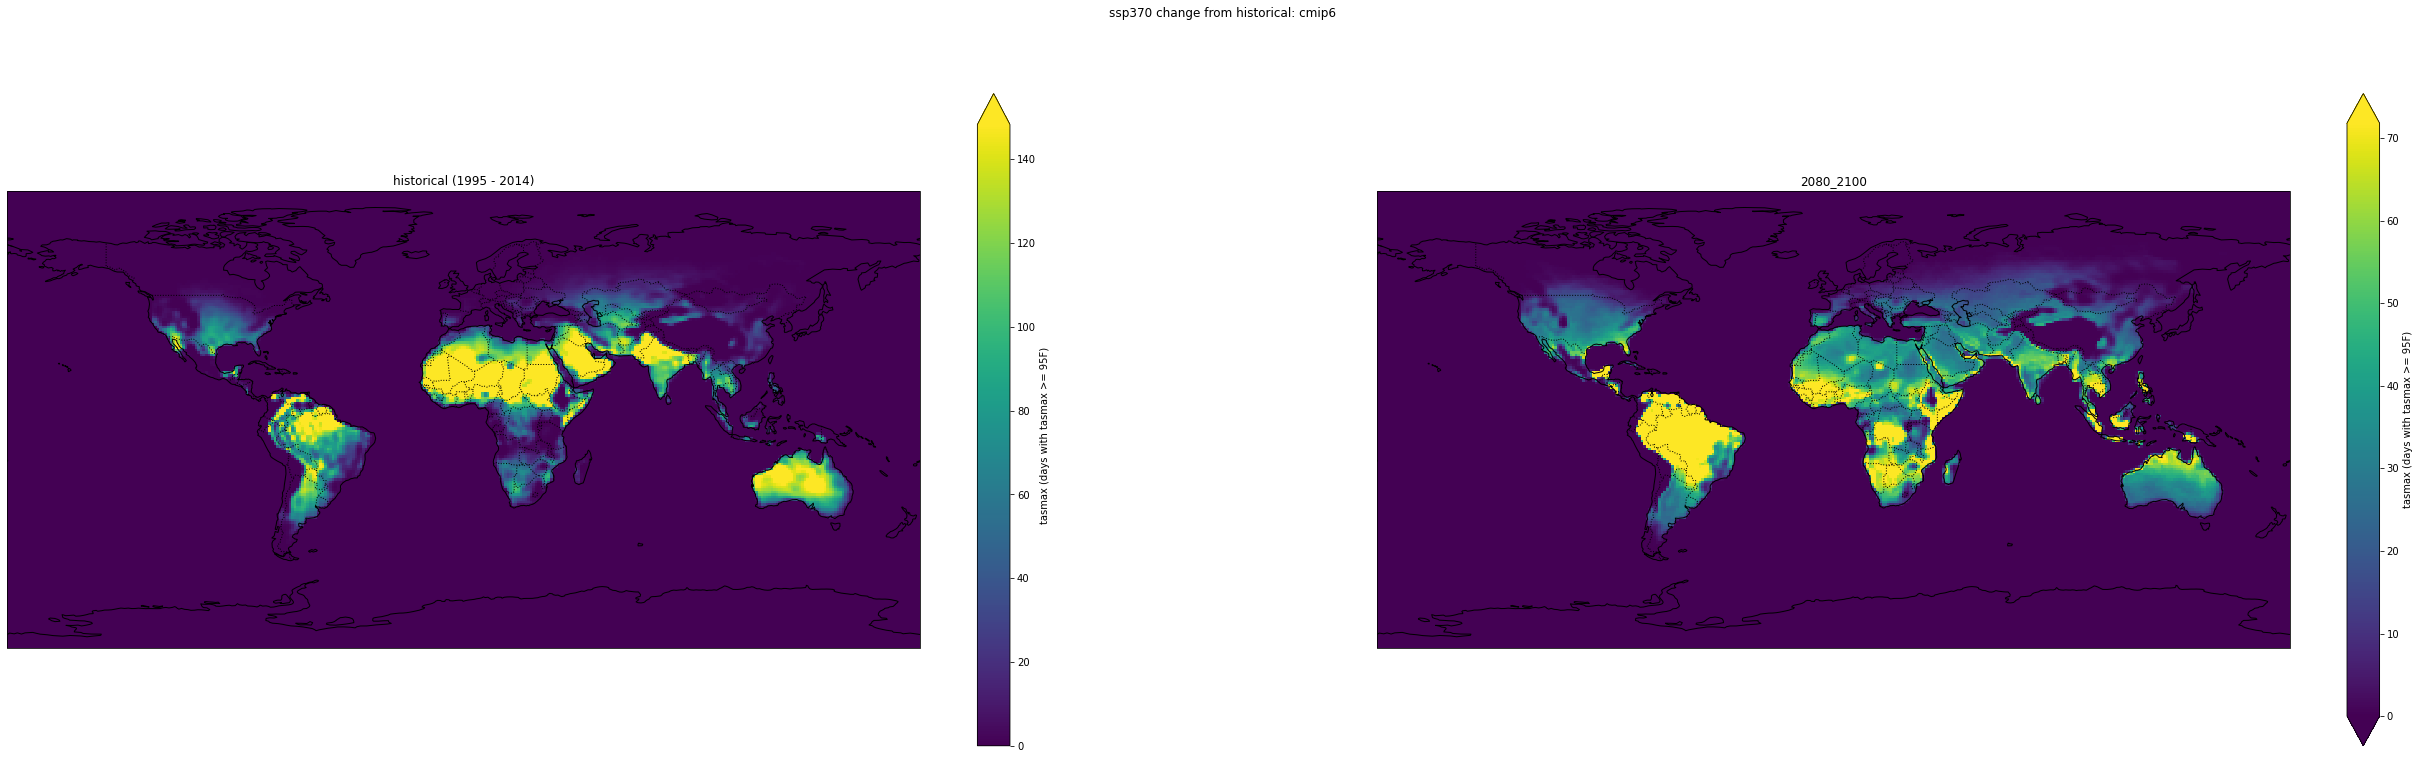

In [25]:
%%time 
if hot_days and cmip6 and difference_plots:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                                                   read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                                   'change_from_historical', 'cmip6', variable, 'days with tasmax >= 95F', years, 
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ds_hist_cmip=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                                                       ssp=ssp, time_period=projection_time_period, xr_func=xr_conditional_count)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

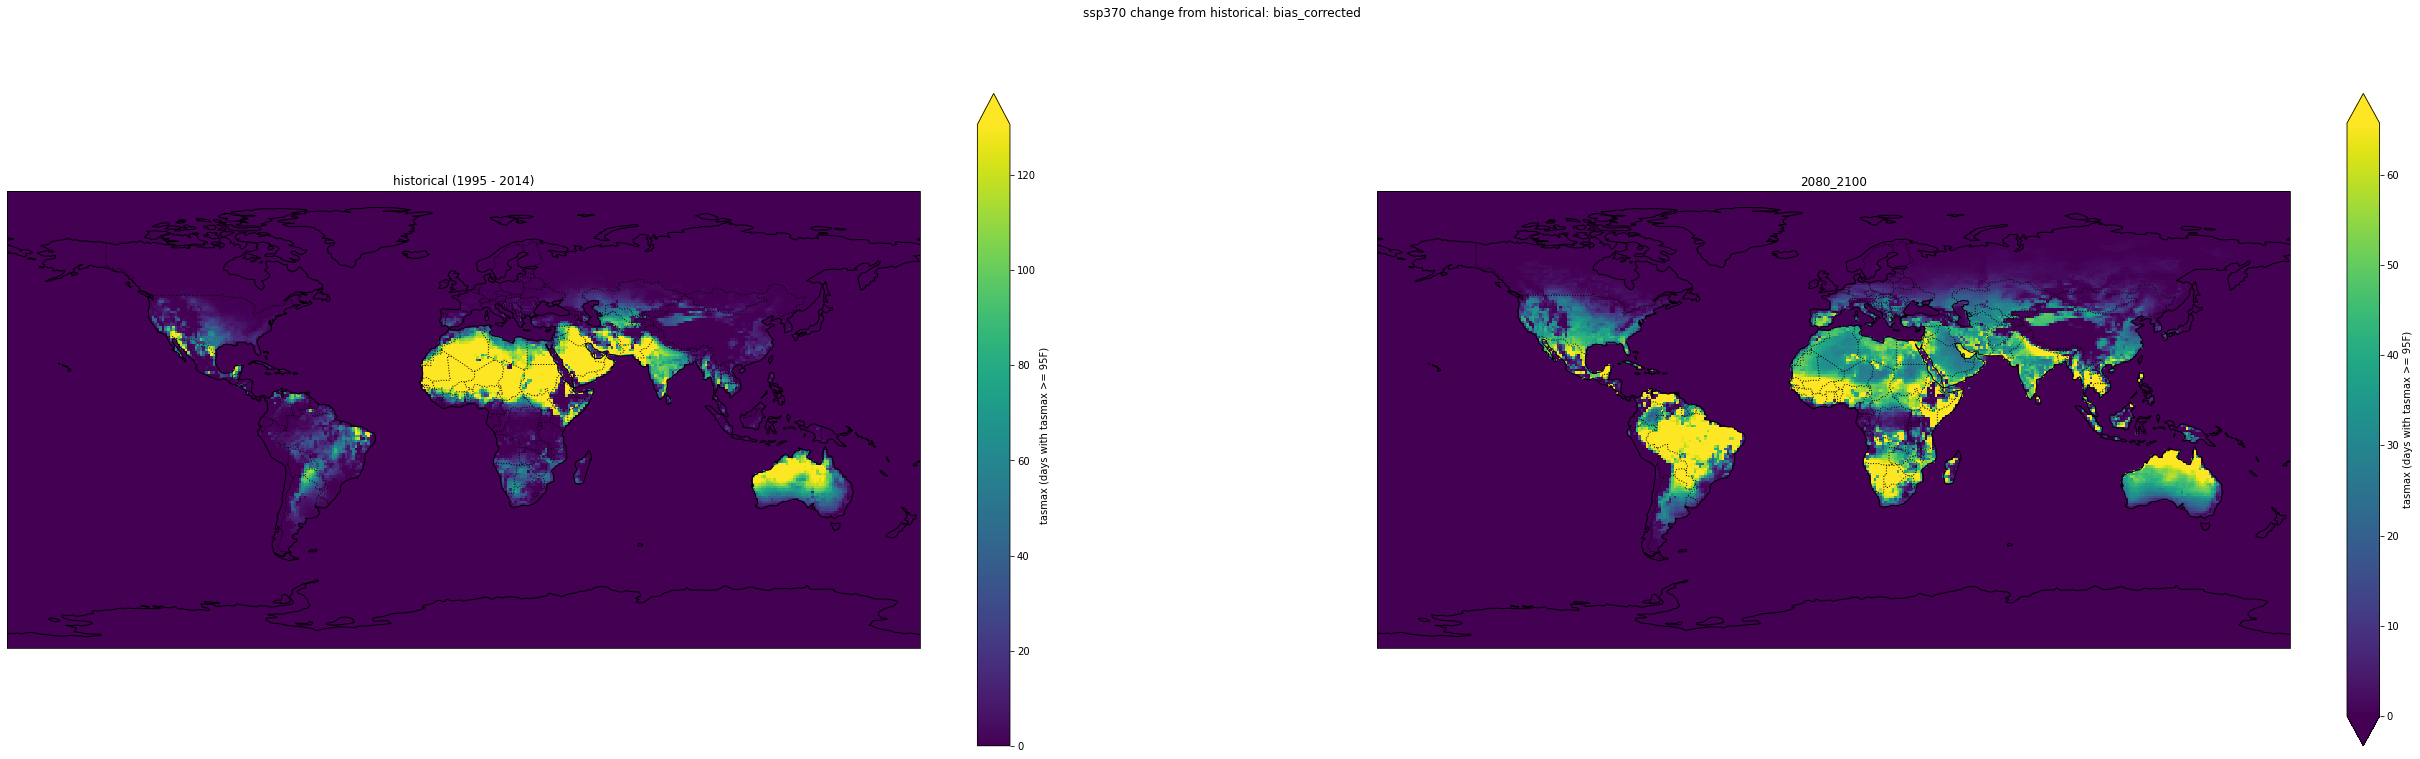

In [42]:
if hot_days and bias_corrected and difference_plots:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                                                   read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                                   'change_from_historical', 'bias_corrected', variable, 'days with tasmax >= 95F', years, 
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ds_hist_cmip=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                                                       ssp=ssp, time_period=projection_time_period, xr_func=xr_conditional_count)

In [ ]:
if hot_days and downscaled and difference_plots:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                                                   read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                                   'change_from_historical', 'downscaled', variable, 'days with tasmax >= 95F', years, 
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ds_hist_cmip=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                                                       ssp=ssp, time_period=projection_time_period, xr_func=xr_conditional_count)

### Precip - dry days ###

In [ ]:
if variable=='pr'
    plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                  ssp, years, variable, basic_diag_type, 'downscaled', 
                                  units[variable], ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']), 
                                  vmin=0, vmax=200, xr_func=xc_maximum_consecutive_dry_days)

### Precip - accumulated ###

In [ ]:
if variable=='pr'
    plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                  ssp, years, variable, basic_diag_type, 'downscaled', 
                                  units[variable], ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']), 
                                  vmin=0, vmax=200, xr_func=xc_maximum_consecutive_dry_days)